In [2]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython import display
from sklearn.model_selection import KFold

from os import listdir,mkdir,rmdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,9]

In [3]:
'''
Setting up code directories
'''

computer = 'Darvin'#'Kotz'

if computer == 'Darvin':
    path_data_root = '/media/darvin/data/Data/saltSegmentation'
elif computer == 'Kotz':
    path_data_root = '/home/kotaro/Projects/data'
    
path_data_tr = join(path_data_root, 'train')
path_data_te = join(path_data_root, 'test')

path_data_tr_imgs = join(path_data_tr, 'images')
path_data_tr_masks = join(path_data_tr, 'masks')

path_data_te_imgs = join(path_data_te, 'images')

In [7]:
'''
Reading in all the images in train.
- images: 4000 image .png's
- masks:  4000 corresponding .png's
'''

X = np.zeros((4000, 1, 128, 128), dtype=np.float32)
Y = np.zeros((4000, 1, 128, 128), dtype=np.float32)
list_names = []

for ii,name_img in enumerate(listdir(path_data_tr_imgs)):
    img  = imageio.imread(join(path_data_tr_imgs, name_img))
    mask = imageio.imread(join(path_data_tr_masks, name_img))
    
    img = np.mean(img, axis=2) / 255
    
    img = np.pad(img, ((13,14), (13,14)), 'constant', constant_values=0)
    mask = np.pad(mask, ((13,14), (13,14)), 'constant', constant_values=0)
    
    X[ii, 0, :, :] = img.astype(np.float32)
    Y[ii, 0, :, :] = (mask > 0).astype(np.float32)
    list_names.append(name_img)

'''
X_tr = X[400:, :, :, :]
Y_tr = Y[400:, :, :, :]

X_va = X[:400, :, :, :]
Y_va = Y[:400, :, :, :]

X_mean = np.mean(X_tr, axis=0)
X_tr -= X_mean
X_va -= X_mean

X_std = np.std(X_tr + 0.000001, axis=(0,1))
X_tr /= X_std + 0.0000001
X_va /= X_std + 0.0000001

print(X_tr.shape, X_va.shape)
'''

'\nX_tr = X[400:, :, :, :]\nY_tr = Y[400:, :, :, :]\n\nX_va = X[:400, :, :, :]\nY_va = Y[:400, :, :, :]\n\nX_mean = np.mean(X_tr, axis=0)\nX_tr -= X_mean\nX_va -= X_mean\n\nX_std = np.std(X_tr + 0.000001, axis=(0,1))\nX_tr /= X_std + 0.0000001\nX_va /= X_std + 0.0000001\n\nprint(X_tr.shape, X_va.shape)\n'

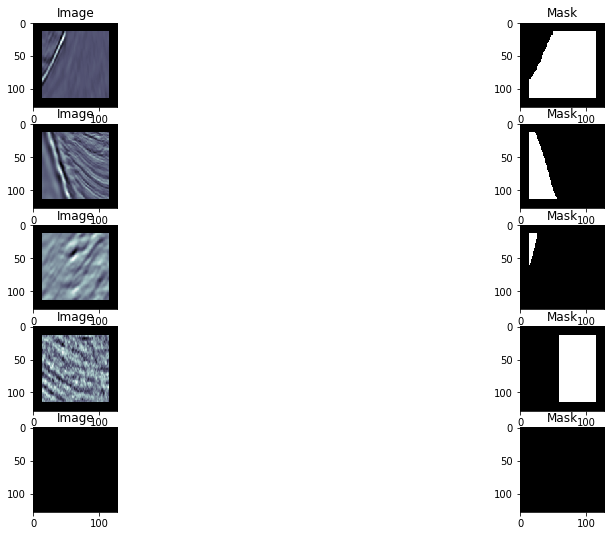

In [8]:
'''
Let's visualize some data.
'''

fig,ax = plt.subplots(5, 2)

inds = np.random.choice(4000, 5)

for ii in range(5):
    ax[ii,0].imshow(X[inds[ii], 0, :, :], cmap='bone')
    ax[ii,0].set_title('Image')
    ax[ii,1].imshow(Y[inds[ii], 0, :, :], cmap='bone')
    ax[ii,1].set_title('Mask')

In [9]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.convT1 = nn.ConvTranspose2d(480, 1, kernel_size=4, stride=2, padding=1, bias=False)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        self.convT2 = nn.ConvTranspose2d(832, 1, kernel_size=8, stride=4, padding=2, bias=False)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.convT3 = nn.ConvTranspose2d(1024, 1, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        out = self.pre_layers(x) #192x64x64
        out = self.a3(out)
        out = self.b3(out)
        pred = self.convT1(out)
        out = self.maxpool(out) #256x32x32
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        pred += self.convT2(out)
        out = self.maxpool(out) #528x16x16
        out = self.a5(out)
        out = self.b5(out)
        pred += self.convT3(out) #1x128x128
        return pred

class Net():
    def __init__(self, lr=0.001, path_save='/home/darvin/hypetrain/saltIdentification/models'):
        self.net = GoogLeNet().cuda()
        #self.opt = optim.Adam(self.net.parameters(), lr=lr)
        self.opt = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9, nesterov=True)
        self.sigm = nn.Sigmoid()
        self.path_save = path_save
        self.best_loss = np.inf
    
    def save_checkpoint(self, name='checkpoint.pth.tar'):
        dict_model = {
            'state_dict': self.net.state_dict(),
            'best_loss': self.best_loss,
            'optimizer': self.opt.state_dict()
        }
        torch.save(dict_model, join(self.path_save, name))
        return 0
    
    def save_model(self, name='best_model.pth.tar'):
        dict_model = {
            'state_dict': self.net.state_dict(),
            'best_loss': self.best_loss,
            'optimizer': self.opt.state_dict()
        }
        torch.save(dict_model, join(self.path_save, name))
        return 0
    
    def load_model(self, name='best_model.pth.tar'):
        checkpoint = torch.load(join(self.path_save, name))
        self.net.state_dict(checkpoint['state_dict'])
        self.update_best_loss(checkpoint['best_loss'])
        self.opt.load_state_dict(checkpoint['optimizer'])
        return 0
    
    def update_best_loss(self, loss):
        self.best_loss = loss
        return 0
    
    def train_one_iter(self, x, y):
        self.opt.zero_grad()
        loss = self.compute_loss(x, y)
        loss.backward()
        self.opt.step()
        return loss
    
    def compute_loss(self, x, y):
        pred = self.predict(x)
        loss = -1 * torch.log(pred) * y - torch.log(1 - pred) * (1 - y)
        return torch.mean(loss)
        
    def predict(self, x):
        out = self.net(x)
        return self.sigm(out)

In [10]:
class train_CV():
    def __init__(self, path_save, X, Y, k=10, X_te=None):
        self.path_save = path_save
        self.X = X
        self.Y = Y
        self.X_te = X_te
        self.k = k
        self.times_tot = []
        self.losses_tr_tot = []
        self.losses_va_tot = []
    
    def do_CV(self):
        kf = KFold(n_splits=self.k)
        kf.get_n_splits(self.X)
        counter = 0.0
        for train_inds, test_inds in kf.split(self.X):
            X_tr,X_va = self.X[train_inds], self.X[test_inds]
            Y_tr,Y_va = self.Y[train_inds], self.Y[test_inds]
            
            X_mean = np.mean(X_tr, axis=0)
            X_tr -= X_mean
            X_va -= X_mean
            X_std = np.std(X_tr + 0.000001, axis=(0,1))
            X_tr /= X_std + 0.0000001
            X_va /= X_std + 0.0000001
            self.train(X_tr,Y_tr,X_va,Y_va, counter)
            counter += 1
        return 0
    
    def train(self, X_tr, Y_tr, X_va, Y_va, counter, epochs=100, batch_size=12):
        times = []
        losses_tr = []
        losses_va = []
        time_start = time.time()
        
        net = Net()
        X_ba = np.zeros((batch_size, 1, 128, 128), dtype=np.float32)
        Y_ba = np.zeros((batch_size, 1, 128, 128), dtype=np.float32)
        for ii in range(epochs):
            net.net.train()
            iters_in_epoch = int(X_tr.shape[0] / batch_size)
            loss_tr = 0.0
            for jj in range(iters_in_epoch):
                inds = np.random.choice(X_tr.shape[0], batch_size)
                for kk,ind in enumerate(inds):
                    img  = X_tr[ind, 0, :, :]
                    mask = Y_tr[ind, 0, :, :]
                    img,mask = self.augment_img(img, mask)
                    X_ba[kk, 0, :, :] = img
                    Y_ba[kk, 0, :, :] = mask
                loss = net.train_one_iter(torch.from_numpy(X_ba).cuda(), torch.from_numpy(Y_ba).cuda())
                loss_tr += loss.cpu().detach().numpy() / iters_in_epoch
            losses_tr.append(loss_tr)

            net.net.eval()
            iters_in_epoch = int( np.floor(X_va.shape[0] / batch_size) )
            loss_va = 0.0
            for kk in range(iters_in_epoch):
                inds = np.arange(kk*batch_size, (kk+1)*batch_size)
                X_ba = X_tr[inds, :, :, :]
                Y_ba = Y_tr[inds, :, :, :]
                loss = net.compute_loss(torch.from_numpy(X_ba).cuda(), torch.from_numpy(Y_ba).cuda())
                loss_va += loss.cpu().detach().numpy() / iters_in_epoch
            losses_va.append(loss_va)
            
            if loss_va < net.best_loss:
                net.update_best_loss(loss_va)
                net.save_model('best_model_CV'+str(int(counter)) + '.pth.tar')
            net.save_checkpoint()

            times.append( (time.time() - time_start) / 60 )
            
            if len(self.times_tot) <= counter:
                self.times_tot.append(times)
                self.losses_tr_tot.append(losses_tr)
                self.losses_va_tot.append(losses_va)
            else:
                c = int(counter)
                self.times_tot[c] = times
                self.losses_tr_tot[c] = losses_tr
                self.losses_va_tot[c] = losses_va
            
            self.plot()
        del net
        return 0
            
    def augment_img(self, img, mask):
        nrot = np.random.choice(4)
        img  = np.rot90(img, nrot)
        mask = np.rot90(mask, nrot)
        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        roller_x = int(np.random.randn() * 20)
        roller_y = int(np.random.randn() * 20)
        img = np.roll(np.roll(img, roller_x, axis=1), roller_y, axis=0)
        mask = np.roll(np.roll(mask, roller_x, axis=1), roller_y, axis=0)
        return img,mask
    
    def plot(self):
        for ii in range(len(self.times_tot)):
            c_b = [0.0, ii / self.k, 1.0]
            c_r = [1.0, ii / self.k, 0.0]
            
            plt.plot(self.times_tot[ii], self.losses_tr_tot[ii], c=c_b)
            plt.plot(self.times_tot[ii], self.losses_va_tot[ii], c=c_r)
            display.clear_output(wait=True)
            display.display(plt.gcf())
    
net = Net()
#print(net.net)

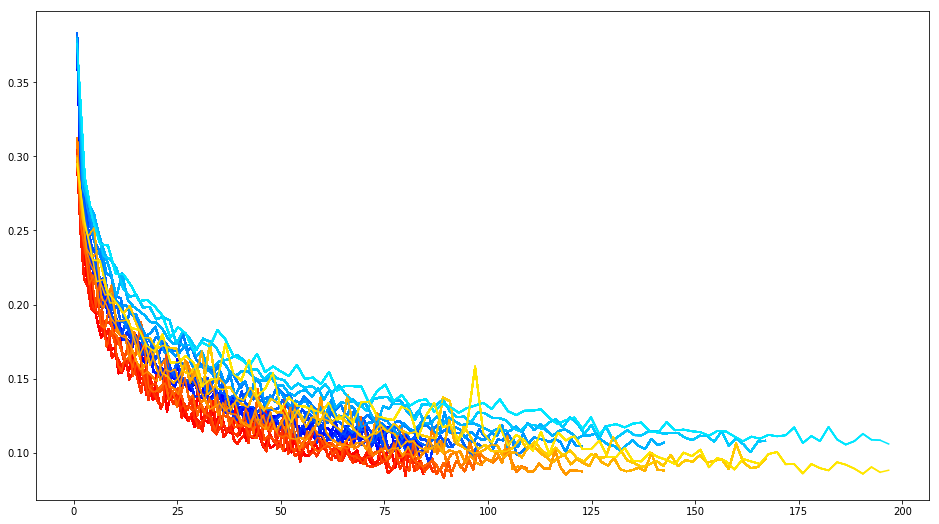

0

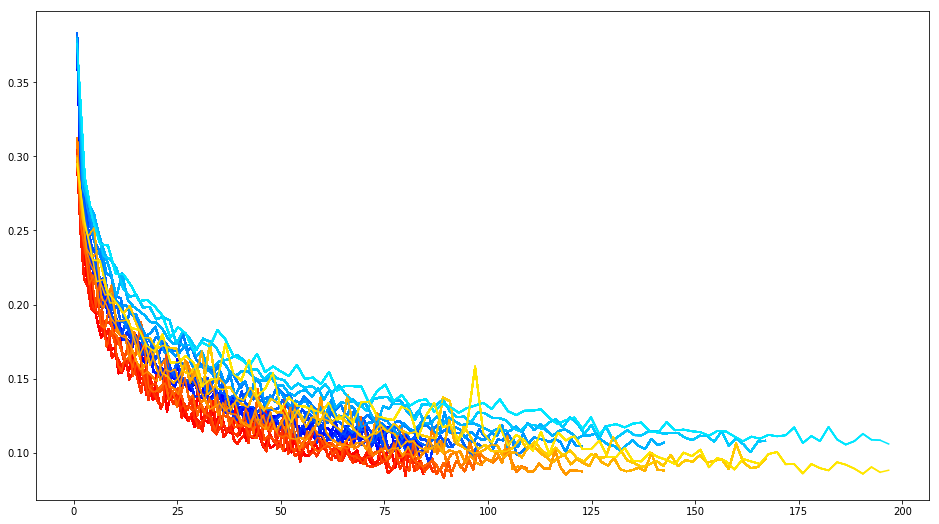

In [11]:
CV_model = train_CV('/home/darvin/hypetrain/saltIdentification/models', X, Y)
CV_model.do_CV()

In [ ]:
ind = 259
fig,ax = plt.subplots(1,3)
ax[0].imshow(X_va[ind,0,:,:])
ax[1].imshow(Y_va[ind,0,:,:])
ax[2].imshow(net.predict(torch.from_numpy(X_va[ind,0,:,:].reshape([1,1,128,128])).cuda()).cpu().detach().numpy().squeeze())

In [ ]:
ii

In [ ]:
plt